# Raw MED_SAM inference

In [1]:
from MEDSAM_helper_functions import *

import sys, os
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '..'))
if not dir1 in sys.path: sys.path.append(dir1)

from utils.environment import setup_data_vars

setup_data_vars()

In [2]:
import argparse
import sys

parser = argparse.ArgumentParser(description="Preprocess CT/MR images")
parser.add_argument('anatomy', type=str, help='anatomy of the images')
parser.add_argument('axis', type=int, help='axis 0,1,2')

original_args = sys.argv
sys.argv = [original_args[0], 'Anorectum', 0]

args = parser.parse_args()

In [3]:
pre_processed_imgs = os.path.join(os.environ.get('MedSAM_preprocessed'), 'imgs', f'axis{args.axis}')
pre_processed_gts = os.path.join(os.environ.get('MedSAM_preprocessed'), 'gts', args.anatomy, f'axis{args.axis}')
pre_processed_imgs, pre_processed_gts

('/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_preprocessed/imgs/axis0',
 '/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_preprocessed/gts/Anorectum/axis0')

In [4]:
from tqdm import tqdm

# Get the image ids and arrange them into slices
gt_slices = os.listdir(pre_processed_gts)
get_id = lambda x: int(x.split('_')[3].split('-')[0])
get_slice = lambda x: int(x.split('_')[3].split('-')[1].split('.')[0])

slices_per_sample = {}
for image_slice in tqdm(os.listdir(pre_processed_gts)):
    gt_id = get_id(image_slice)
    gt_slice = get_slice(image_slice)

    if gt_id not in slices_per_sample:
        slices_per_sample[gt_id] = [gt_slice, gt_slice] # (min, max)
    else:
        min_slice, max_slice = slices_per_sample[gt_id]
        slices_per_sample[gt_id] = (min([min_slice, gt_slice]), max([max_slice, gt_slice]))

print(f'Found {len(gt_slices)} distinct image slices for this axis ({args.axis}) and anatomy ({args.anatomy})')
slice_intervals = [mx - mn + 1 for mn, mx in slices_per_sample.values()]
print(f'Average slices per sample: {np.mean(slice_intervals)}')
print(f'The most slices per sample: {np.max(slice_intervals)}')
print(f'The least slices per sample: {np.min(slice_intervals)}')

  0%|          | 0/5196 [00:00<?, ?it/s]

100%|██████████| 5196/5196 [00:00<00:00, 196170.88it/s]

Found 5196 distinct image slices for this axis (0) and anatomy (Anorectum)
Average slices per sample: 52.05
The most slices per sample: 74
The least slices per sample: 31


## Set up model

In [5]:
MedSAM_CKPT_PATH = os.path.join(os.environ.get('PROJECT_DIR'),  "models/MedSAM/work_dir/MedSAM/medsam_vit_b.pth")
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()
"model set to evaluation mode"

'model set to evaluation mode'

## Infer each bounding box separately

In [6]:
batch_size = 2
box_limit = 2

dataset = SAM_Dataset(axis=args.axis, anatomy=args.anatomy, box_limit=box_limit, box_padding=0)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for img, gt, boxes, imgids, currslice in loader:
    img = img.to(device)
    B, C, H, W = img.shape

    with torch.no_grad():
            image_embedding = medsam_model.image_encoder(img)

    per_batch_boxes = boxes.transpose(1, 0)
    
    # medsam_preds = []
    # for b in per_batch_boxes:
    #     batch_prediction = medsam_inference(medsam_model, image_embedding, b.reshape(-1, 1, 4) , H, W)
    #     for i in range(batch_size):
    #         visualise_bounding_box_with_prediction(img[i].permute(1, 2, 0).cpu().numpy()
    #                                             , gt[i]
    #                                             , b[None, i]
    #                                             , batch_prediction[i]
    #                                             , show_boxes_of_predictions=True
    #                                             , sup_title=f"Image ID: {imgids[i]}, Slice: {currslice[i]}")
    #     medsam_preds.append(batch_prediction)

    medsam_preds = np.array([medsam_inference(medsam_model, image_embedding, H, W, b.reshape(-1, 1, 4)) for b in per_batch_boxes])
#     combined_preds = np.logical_or.reduce(np.array(medsam_preds)).astype(np.uint8)
    
    break

(0, 0), Image ID: 43, Slice: 109, Dice Score: 0.9482049876678542


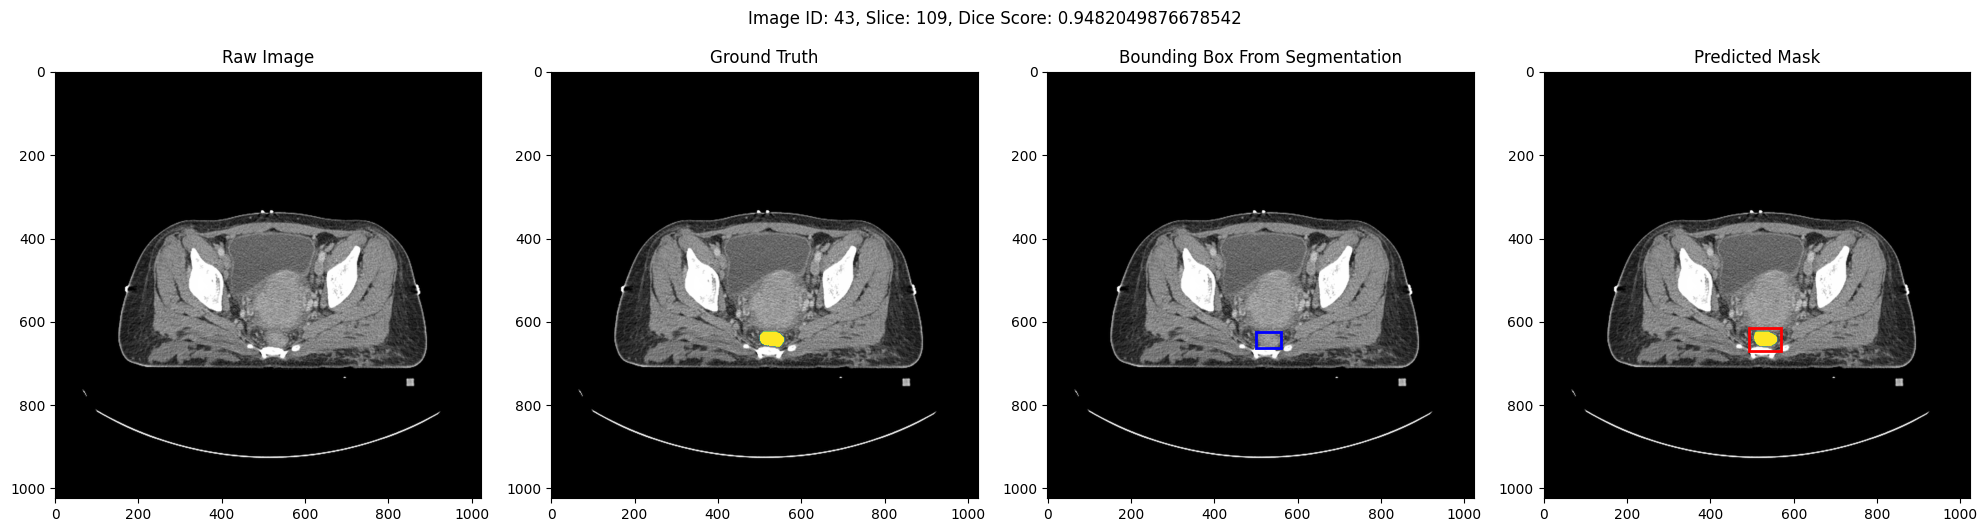

(0, 1), Image ID: 43, Slice: 109, Dice Score: 0.9482049876678542


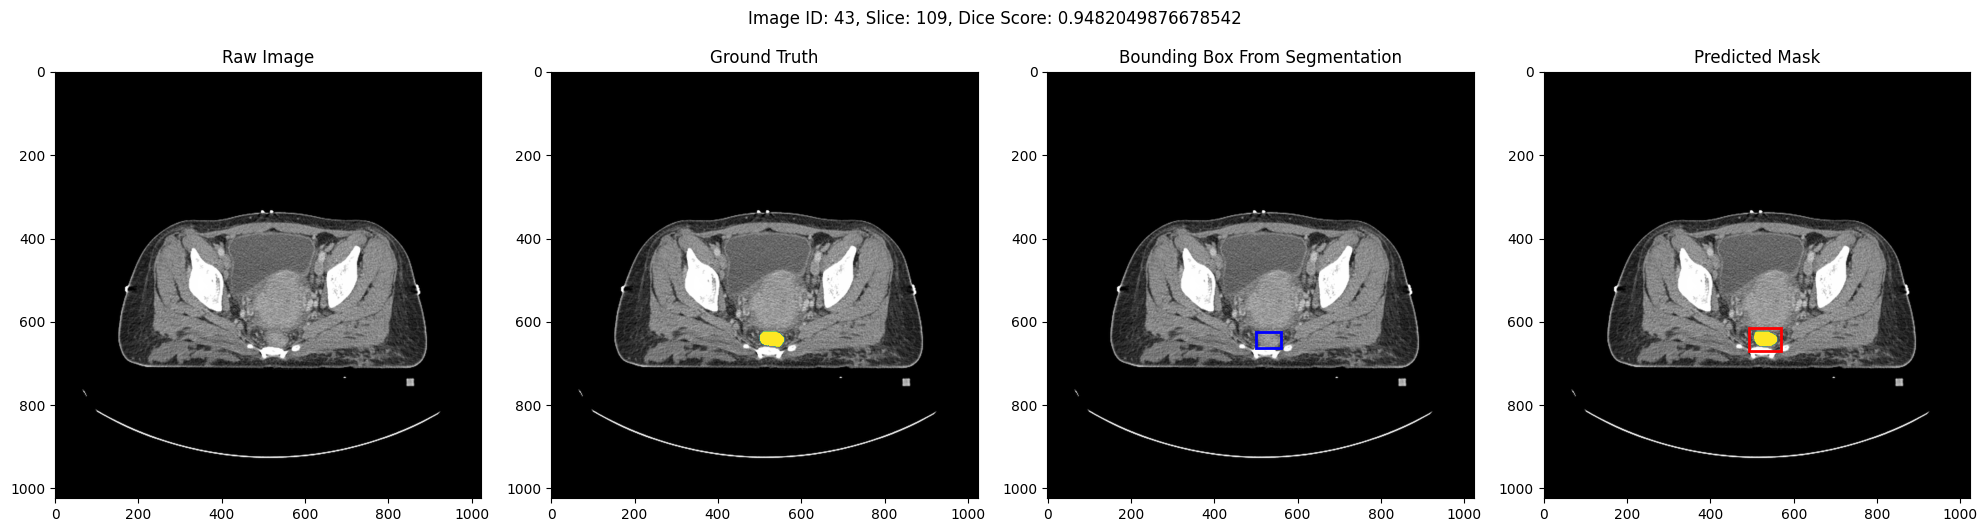

(1, 0), Image ID: 17, Slice: 55, Dice Score: 0.7824310520939735


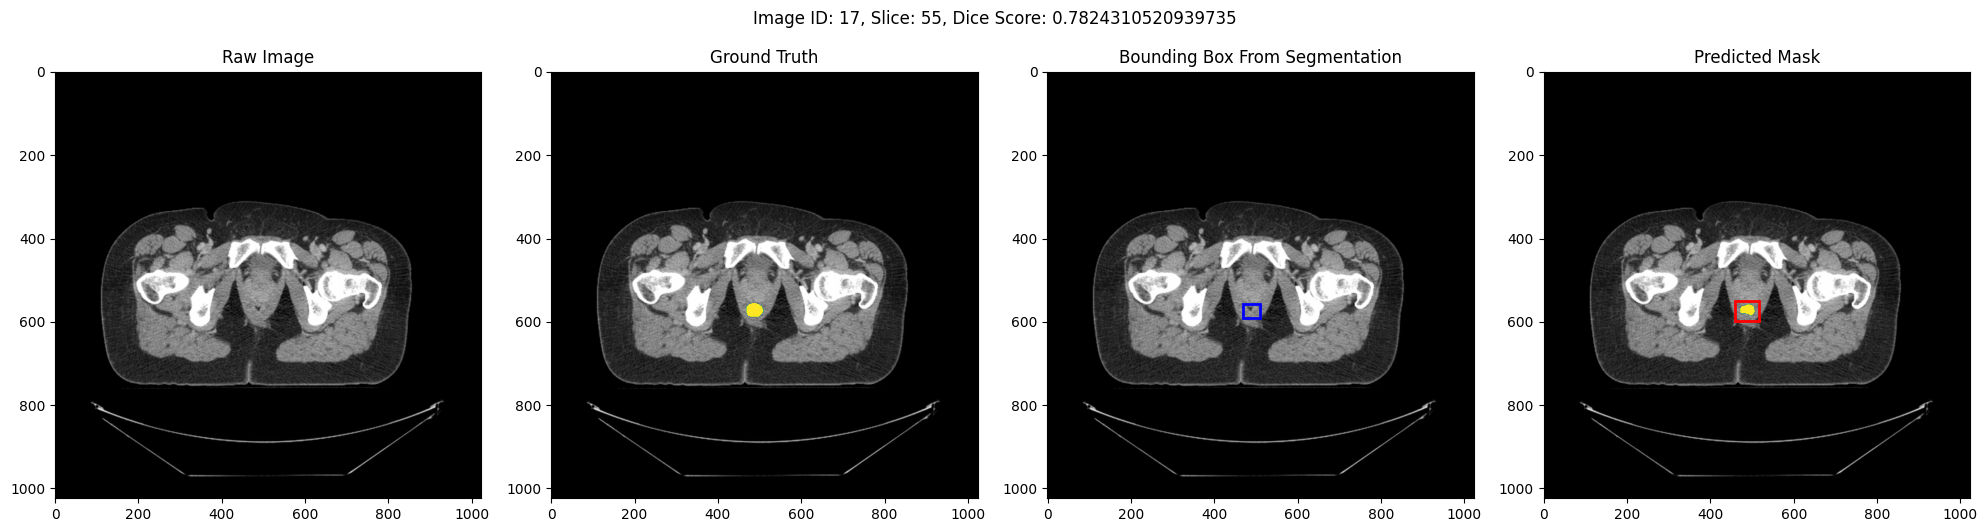

(1, 1), Image ID: 17, Slice: 55, Dice Score: 0.7824310520939735


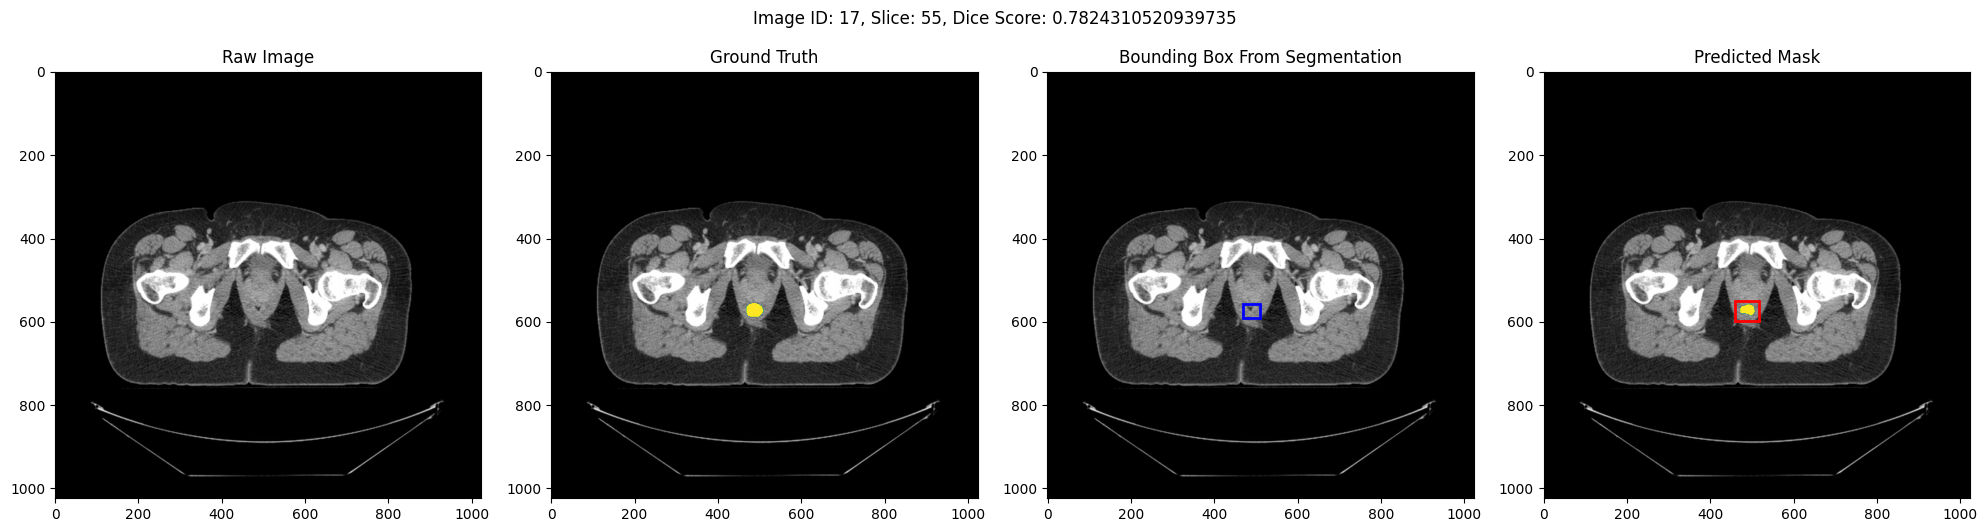

In [7]:
view_medsam_preds = medsam_preds.swapaxes(0, 1)

# Iterate over the images and extract the bounding box predictions
for (i, j) in ((a, b) for a in range(batch_size) for b in range(box_limit)):
    dice_score = dice_similarity(gt[i], view_medsam_preds[i][j])
    print(f"{(i,j)}, Image ID: {imgids[i]}, Slice: {currslice[i]}, Dice Score: {dice_score}")

    visualise_bounding_box_with_prediction(array_image = img[i].permute(1, 2, 0).cpu().numpy(),
                                           array_gt_label = gt[i],
                                           bounding_boxes = boxes[i][None, j],
                                           predicted_mask = view_medsam_preds[i][j],
                                           show_boxes_of_predictions=True,
                                           sup_title=f"Image ID: {imgids[i]}, Slice: {currslice[i]}, Dice Score: {dice_score}")

## Combine each prediction into one for total inference

In [8]:
sys.argv = [original_args[0], 'Bladder', 0]

In [9]:
batch_size = 2
box_limit = 2

dataset = SAM_Dataset(axis=args.axis, anatomy=args.anatomy, box_limit=box_limit, box_padding=0)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for img, gt, boxes, imgids, currslice in loader:
    img = img.to(device)
    B, C, H, W = img.shape

    with torch.no_grad():
            image_embedding = medsam_model.image_encoder(img)

    per_batch_boxes = boxes.transpose(1, 0)

    medsam_preds = np.array([medsam_inference(medsam_model, image_embedding , H, W, b.reshape(-1, 1, 4)) for b in per_batch_boxes])
    combined_preds = np.logical_or.reduce(np.array(medsam_preds)).astype(np.uint8)
    
    break

In [10]:
# Iterate over the images and extract the bounding box predictions
for i in range(batch_size):
    print(f"{(i)}, Image ID: {imgids[i]}, Slice: {currslice[i]}")

    dice_score = dice_similarity(gt[i], combined_preds[i])
    title = f"Image ID: {imgids[i]}, Slice: {currslice[i]}, Dice Score: {dice_score}"

    visualise_bounding_box_with_prediction(array_image = img[i].permute(1, 2, 0).cpu().numpy(),
                                        array_gt_label = gt[i],
                                        bounding_boxes = boxes[i],
                                        predicted_mask = combined_preds[i],
                                        show_boxes_of_predictions=True,
                                        sup_title=title,
                                        save_title=f'./results/{args.anatomy}/axis{args.axis}/{imgids[i]}_{currslice[i]}_{dice_score}.png')

    # visualise_bounding_box_with_prediction(img[i].permute(1, 2, 0).cpu().numpy(),
    #                                        gt[i],
    #                                        boxes[i],
    #                                        combined_preds[i],
    #                                        show_boxes_of_predictions=True,
    #                                        sup_title=title,
    #                                        save_title=f'./results/{args.anatomy}/axis{args.axis}/{imgids[i]}_{currslice[i]}_{dice_score}.png')

0, Image ID: 39, Slice: 98
1, Image ID: 87, Slice: 116


## Get predictions for each anatomy

In [11]:
import logging 
from tqdm import tqdm
logging.basicConfig(filename='results/dice_scores_axis_2.1.log', filemode='w', format='%(name)s - %(levelname)s - %(message)s', level=logging.INFO)

save_dir = os.path.join(os.environ.get('MedSAM_results'))

for axis in [2] : # [0,1,2]:
    for anatomy in tqdm(['Bladder', 'Anorectum', 'CTVn', 'CTVp', 'Parametrium', 'Vagina', 'Uterus'], desc=f'Running predictions for axis 2 across all anatomies'):

        save_path = os.path.join(save_dir, anatomy, f'axis{axis}')
        os.makedirs(save_path, exist_ok=True)
        batch_size = 8
        box_limit = 2

        dataset = SAM_Dataset(axis=axis, anatomy=anatomy, box_limit=box_limit, box_padding=0)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for img, gt, boxes, imgids, currslice in tqdm(loader):
            img = img.to(device)
            B, C, H, W = img.shape

            with torch.no_grad():
                    image_embedding = medsam_model.image_encoder(img)

            per_batch_boxes = boxes.transpose(1, 0)

            medsam_preds = np.array([medsam_inference(medsam_model, image_embedding, H, W, b.reshape(-1, 1, 4)) for b in per_batch_boxes])
            combined_preds = np.logical_or.reduce(np.array(medsam_preds)).astype(np.uint8)
            
            for i in range(B):
                # Save prediction
                np.save(os.path.join(save_path, f'{imgids[i]}-{currslice[i]}.npy'), combined_preds[i])

                #  calcualte the DICE score
                dice_score = dice_similarity(gt[i], combined_preds[i])
                logging.info(f'{anatomy} - {axis} - {imgids[i]} - {currslice[i]} - {dice_score}')

        # # Iterate over the images and extract the bounding box predictions
        # for i in range(batch_size):
        #     print(f"{(i)}, Image ID: {imgids[i]}, Slice: {currslice[i]}")

        #     dice_score = dice_similarity(gt[i], combined_preds[i])

        #     visualise_bounding_box_with_prediction(img[i].permute(1, 2, 0).cpu().numpy(),
        #                                         gt[i],
        #                                         boxes[i],
        #                                         combined_preds[i],
        #                                         show_boxes_of_predictions=True,
        #                                         sup_title=f"Image ID: {imgids[i]}, Slice: {currslice[i]}, Dice Score: {dice_score}",
        #                                         save_title=f'./results/{anatomy}/axis{axis}/{imgids[i]}_{currslice[i]}_{dice_score}.png')

        # Done 14

  0%|          | 0/2328 [00:00<?, ?it/s]

 94%|█████████▍| 2193/2328 [2:01:48<09:17,  4.13s/it]  

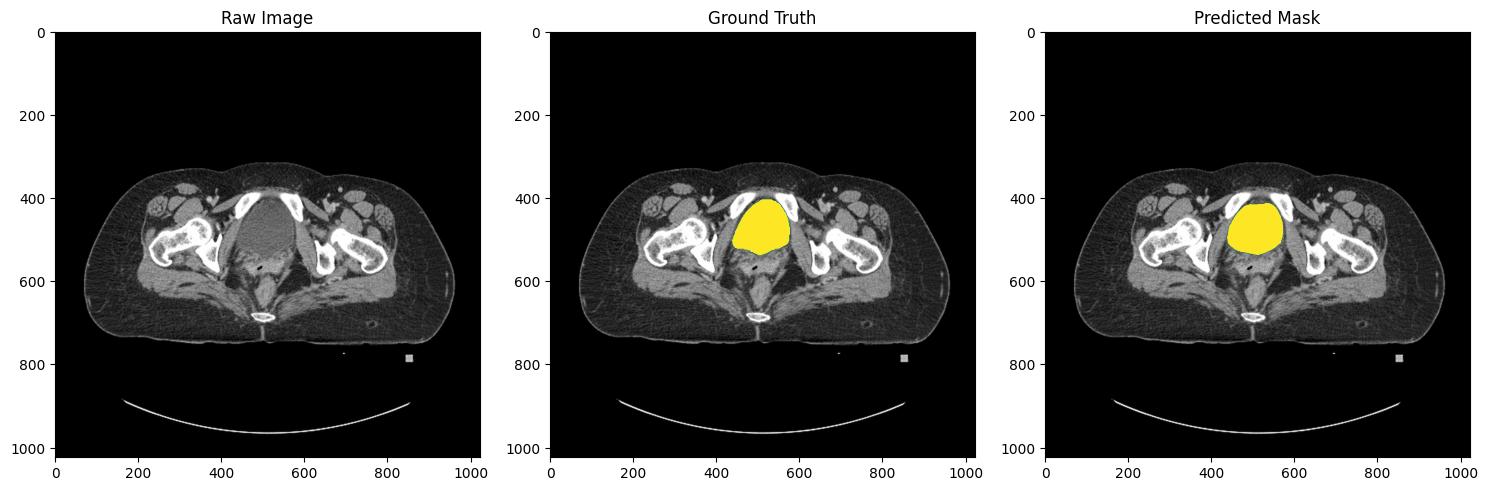

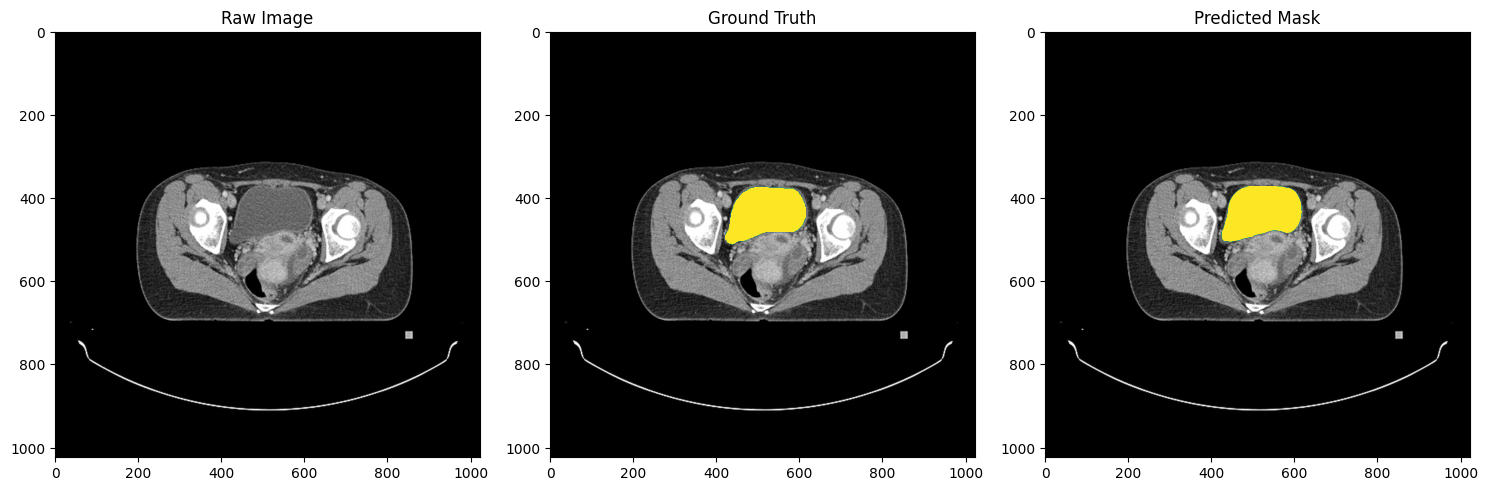

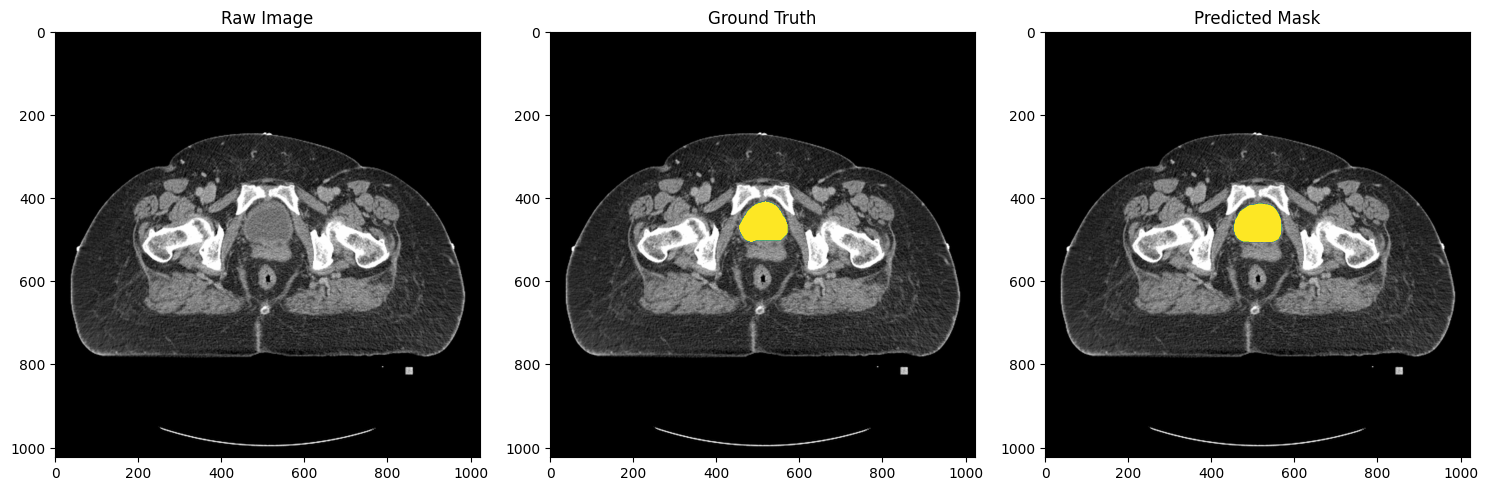

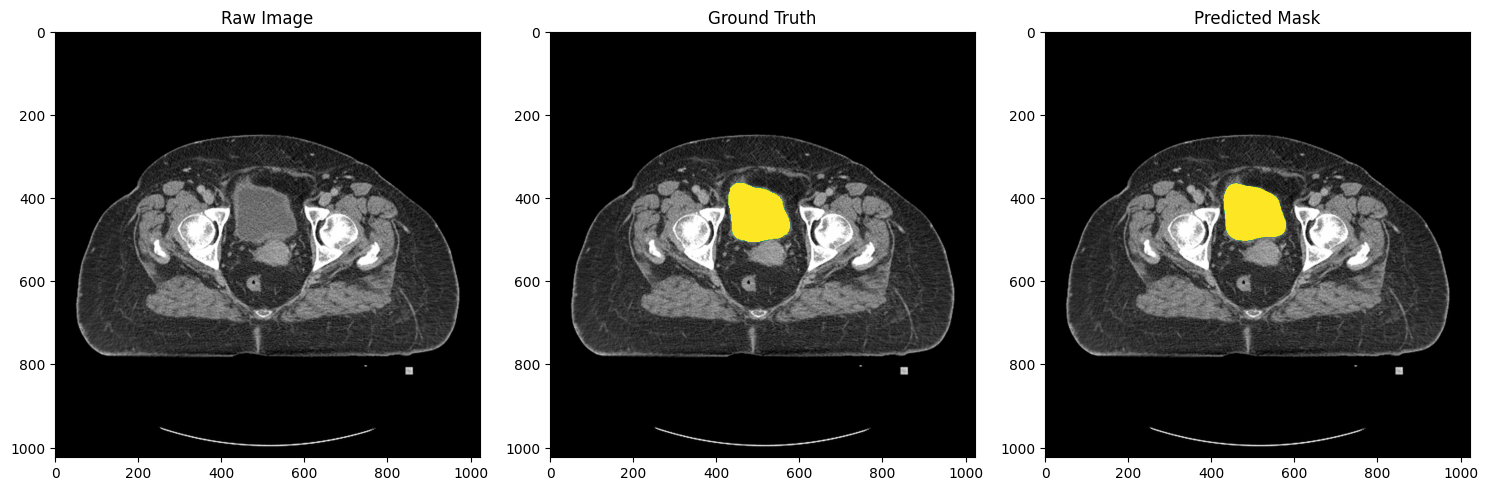

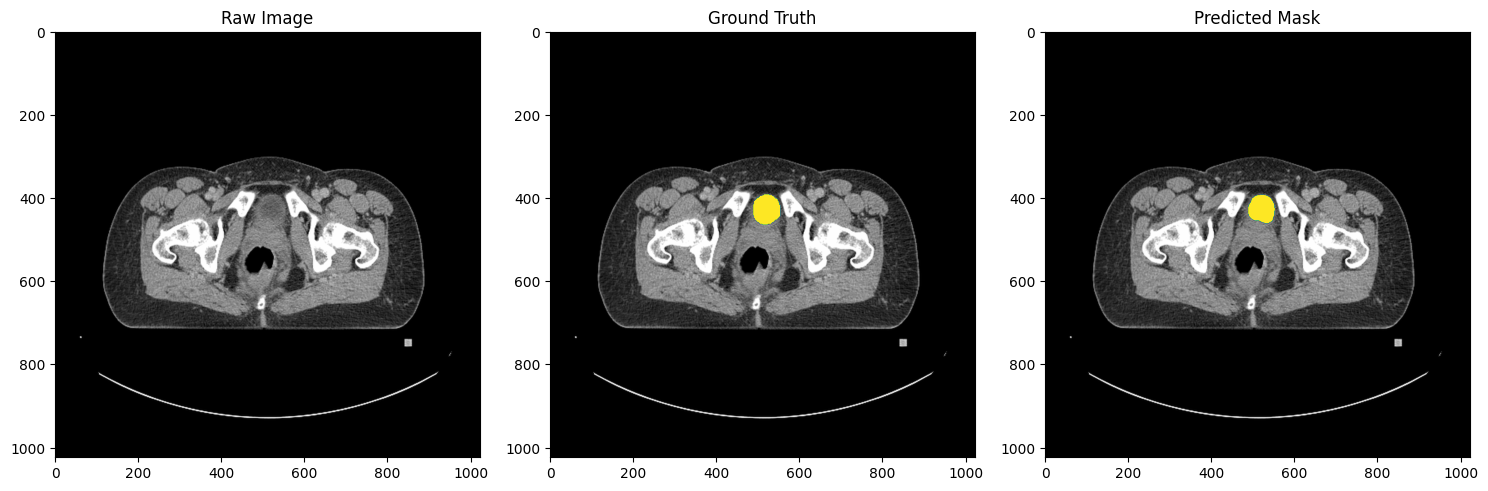

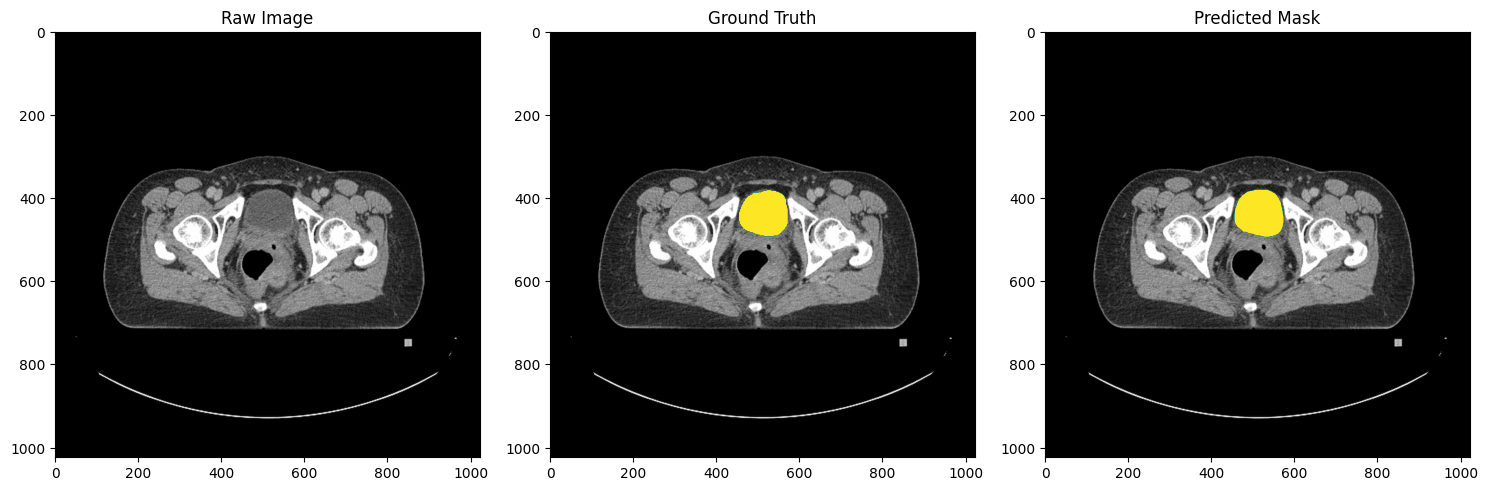

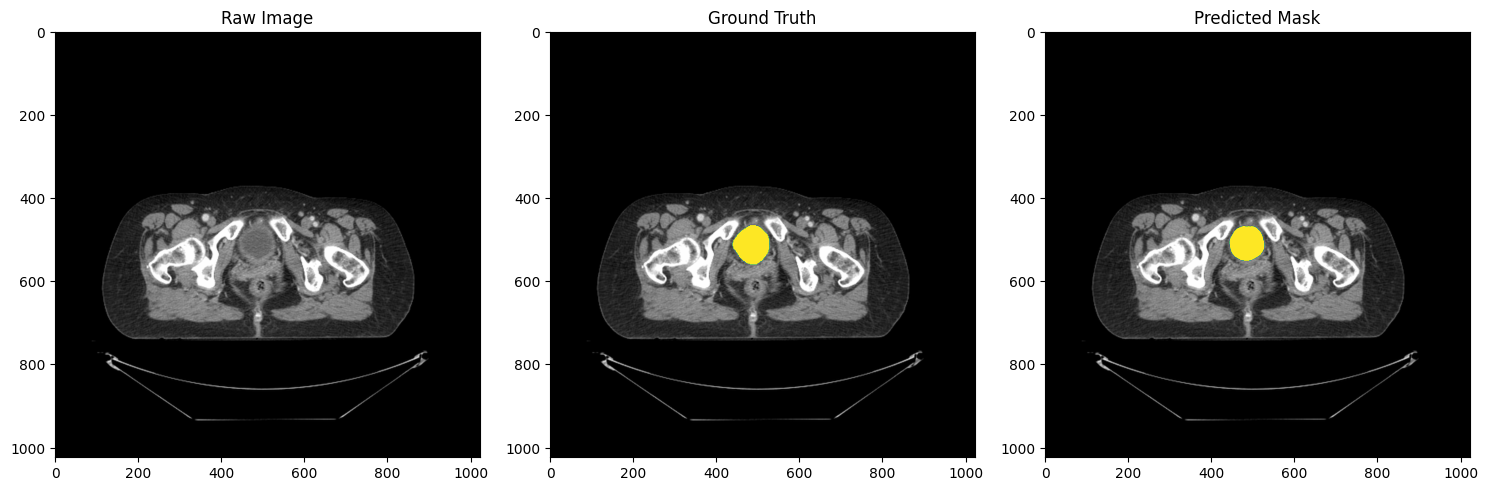

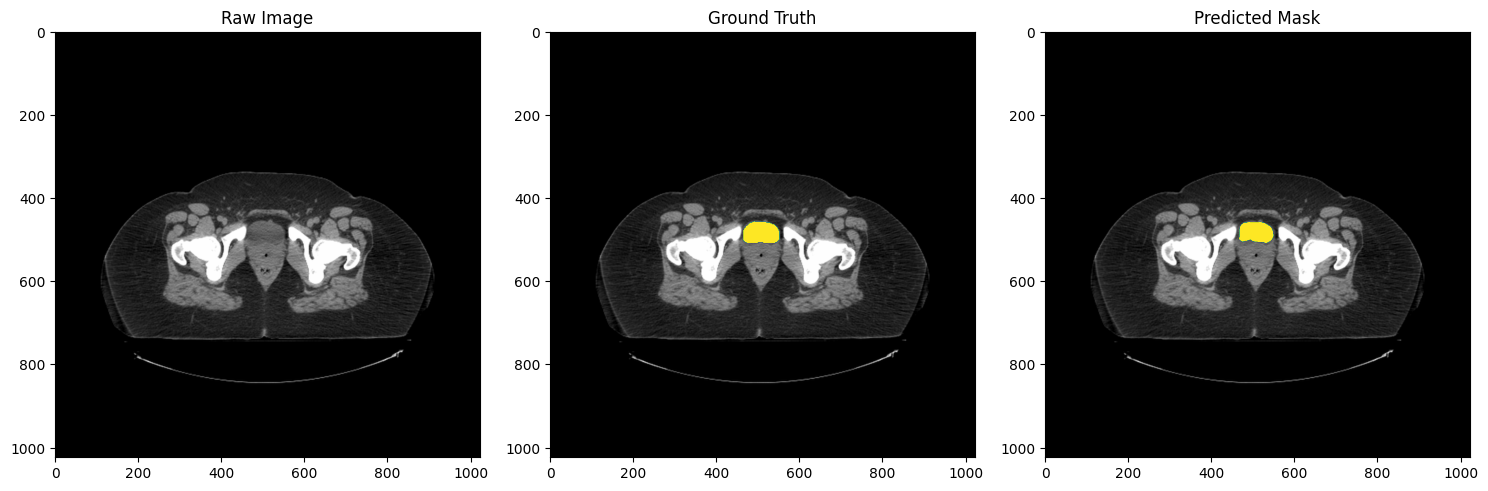

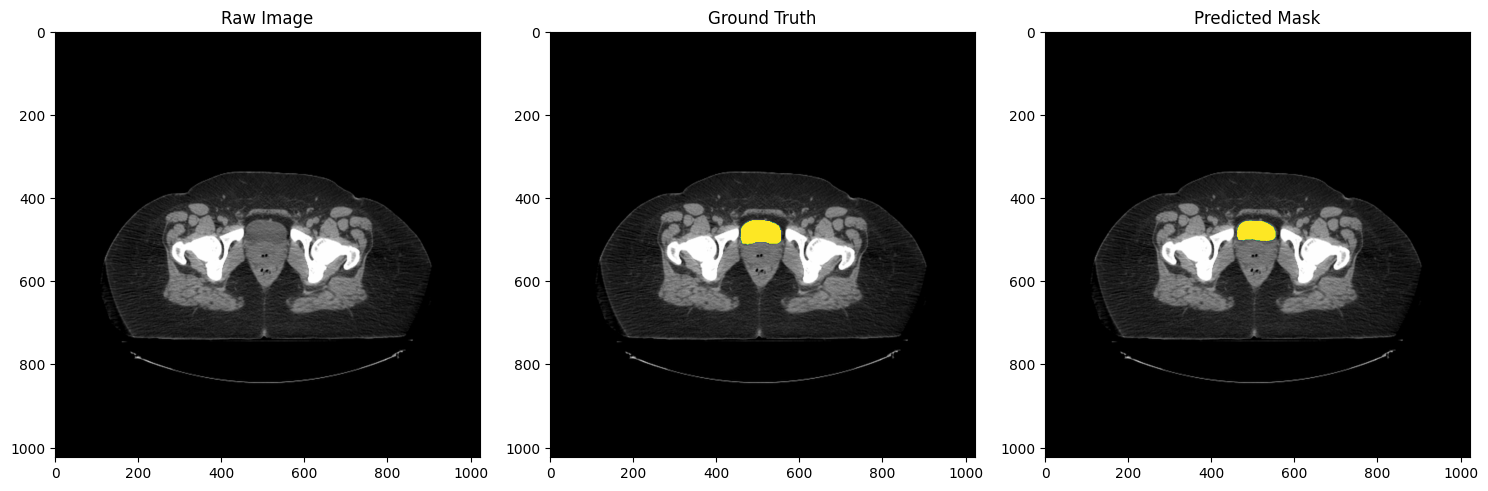

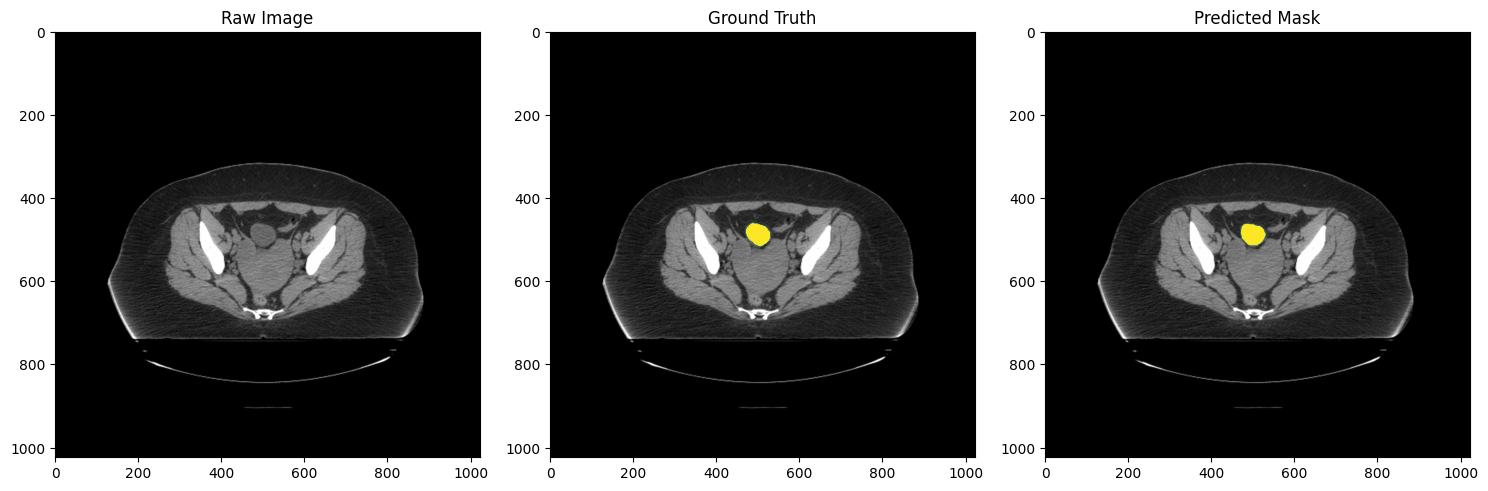

In [22]:
# # Make sure that the saved predictions are being saved ok
# # From my check, these seem ok.

# # I'll pick id = 1, slice = 92
# img_id = [1,2,3,3,4,4,5,6,6,6]
# slice_num = [92,72,82,92,76,79,55,67,68,93]
# anatomy = 'Bladder'
# axis = 0

# for ii, sn in zip(img_id, slice_num):
#     gt_slice_path = os.path.join(os.environ.get('MedSAM_preprocessed'), 'gts', anatomy, f'axis{axis}', f'CT_{anatomy}_zzAMLART_{str(ii).zfill(3)}-{str(sn).zfill(3)}.npy')
#     img_slice_path = os.path.join(pre_processed_imgs, f'CT_zzAMLART_{str(ii).zfill(3)}-{str(sn).zfill(3)}.npy')
#     pred_path = os.path.join(save_dir, anatomy, f'axis{axis}', f'{ii}-{sn}.npy')

#     gt_array = np.load(gt_slice_path)
#     img_array = np.load(img_slice_path)
#     pred_array = np.load(pred_path)

#     visualise_bounding_box_with_prediction(img_array, gt_array, predicted_mask=pred_array)